In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [4]:
%matplotlib widget

# Load experiment list

In [5]:
plotdir = r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\pictures and plots\LFP time freq"

In [6]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100


# Test one session

In [23]:
choose_sub = 4
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
exp_tag = exprow.exp_folder[:9]
print(exp_tag)

Experiment type: electrical stimulation
THstim_d1


In [24]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [25]:
print(stim_elec_data['tip']['area'])

AV


## Load all data

### Stim log

In [26]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [27]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [28]:
simple_log

,stim_type,parameter,duration,onset,offset,sweep
0,freq50Hz,10,20,1401.91070,1421.91083,0
1,freq50Hz,20,20,1524.83939,1544.83952,0
2,freq50Hz,30,20,1675.01610,1695.01623,0
3,freq50Hz,40,20,1821.29232,1841.29245,0
4,freq50Hz,40,40,1967.67782,2007.67808,0
5,freq50Hz,50,20,2151.04644,2171.04657,0
6,freq50Hz,50,40,2317.26693,2357.26717,0
7,freq50Hz,60,20,2500.46533,2520.46545,0
8,freq50Hz,70,20,2616.89479,2636.89491,0
9,freq50Hz,80,20,2729.82390,2749.82401,0


### Iso times

In [29]:
iso_induction, iso_maintenance = exp.load_iso_times()

### Pupil

In [30]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilD)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        sm_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilD[:k]
    sm_pupil[-k-1:] = pupilD[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilD)) / len(pupilD)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [31]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])

### Running

In [32]:
running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

### Load probe LFP

In [33]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeA', 'probeD', 'probeE', 'probeF']


In [34]:
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    probe_areas = np.array(data['area_ch'])
    print(np.unique(probe_areas))
    print('')

probeA
['ACAd5' 'ACAv5' 'DP' 'ILA5' 'LSr' 'MOs1' 'MOs2/3' 'MOs5' 'OLF' 'PL5'
 'STR' 'TTd' 'null']

probeD
['APN' 'HPF' 'NOT' 'SUB' 'VISp1' 'VISp2/3' 'VISp4' 'VISp5' 'VISp6a'
 'VISp6b' 'alv' 'dhc' 'fp' 'null' 'or' 'root']

probeE
['CA1' 'CA2' 'CA3' 'DG-mo' 'LGd-co' 'LP' 'PO' 'SSp-bfd1' 'SSp-bfd2/3'
 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a' 'SSp-bfd6b' 'alv' 'ccs' 'null' 'or']

probeF
['ACAd6a' 'ACAd6b' 'CP' 'MOs1' 'MOs2/3' 'MOs5' 'MOs6a' 'SEZ' 'VL' 'ccg'
 'cing' 'null']



In [41]:
probe_name = 'probeF'

## Load LFP as memmap ##
# lfp_ts = np.load(exp.ephys_params[probe_name]['lfp_timestamps'])
# lfp_data_mm = np.memmap(exp.ephys_params[probe_name]['lfp_continuous'], dtype='int16', mode='r').reshape(
#     (len(lfp_ts), exp.ephys_params[probe_name]['num_chs']))

## Load probe_info.json ##
with open(exp.ephys_params[probe_name]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
probe_ch_depths = allch_z[surface_ch] - allch_z
probe_areas = np.array(data['area_ch'])

In [42]:
area_chs = np.nonzero(probe_areas == 'MOs5')[0]
print(area_chs)

[162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210]


## Collect LFP from different cortical areas

Get the total LFP and timestamps, apply bandpass filter, store in dict.

In [43]:
collect_LFP = {
    'probeA': {'ACAd': 268},
    'probeD': {'VISp': 228},
    'probeE': {'SSp-bfd': 290},
    'probeF': {'MOs': 188},
}
deltat = 10. # window size, s
ctx_LFPs = {}
ctx_spectra = {}
for probei, chinfo in collect_LFP.items():
    print(probei)
    ## Load LFP as memmap ##
    lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
    lfp_data_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', mode='r').reshape(
        (len(lfp_ts), exp.ephys_params[probei]['num_chs']))
    for regi, chi in chinfo.items():
        print(' {}: Loading data...'.format(regi))
        ## Get chosen ch converted ##
        lfp_ch = lfp_data_mm[:, chi] * exp.ephys_params[probei]['bit_volts']
        ## Apply bandpass filter (reverse, filter in 1 direction, and reverse again to correct for analog filter phase shift) ##
        hardware_filter = signal.butter(1, Wn=[0.5, 500], btype='band', fs=exp.ephys_params[probei]['lfp_sample_rate'])
        lfp_ch = np.flip(signal.lfilter(*hardware_filter, np.flip(lfp_ch)))
        ## Store the LFP ##
        ctx_LFPs[regi] = [lfp_ts, lfp_ch]
    
        lfp_fs = exp.ephys_params[probei]['lfp_sample_rate']
        
        ### Get the spectra for rest/run/iso ###
        print('  Getting spectra...')
        ctx_spectra[regi] = {}
        ## Get deltat-sized bins and associated speeds ##
        awakebins = np.arange(lfp_ts[0], iso_induction[0], deltat)
        firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
        isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)
        tempsp = []
        for x in awakebins:
            tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
        awakespeeds = np.array(tempsp)[:-1]
        tempsp = []
        for x in isobins:
            tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
        isospeeds = np.array(tempsp)[:-1]
        ## Get awake spectra ##
        awake_Pxx = []
        for timei in awakebins[:-1]:
            tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
            frex, Pxx = signal.welch(
                lfp_ch[tinds], exp.ephys_params[probei]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probei]['lfp_sample_rate'],
            )
            awake_Pxx.append(Pxx)
        awake_Pxx = np.array(awake_Pxx)
        ctx_spectra[regi]['rest'] = [frex, np.mean(awake_Pxx[awakespeeds == 0, :], axis=0)]
        ctx_spectra[regi]['run'] = [frex, np.mean(awake_Pxx[awakespeeds > 1, :], axis=0)]
        ## Get anesthetized spectra ##
        iso_Pxx = []
        for timei in isobins[:-1]:
            tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
            frex, Pxx = signal.welch(
                lfp_ch[tinds], exp.ephys_params[probei]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probei]['lfp_sample_rate'],
            )
            iso_Pxx.append(Pxx)
        iso_Pxx = np.array(iso_Pxx)
        ctx_spectra[regi]['iso'] = [frex, np.mean(iso_Pxx[isospeeds == 0, :], axis=0)]
        print('  ...done.\n')

probeA
 ACAd: Loading data...
  Getting spectra...


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


  ...done.

probeD
 VISp: Loading data...
  Getting spectra...
  ...done.

probeE
 SSp-bfd: Loading data...
  Getting spectra...
  ...done.

probeF
 MOs: Loading data...
  Getting spectra...
  ...done.



Plot the spectra

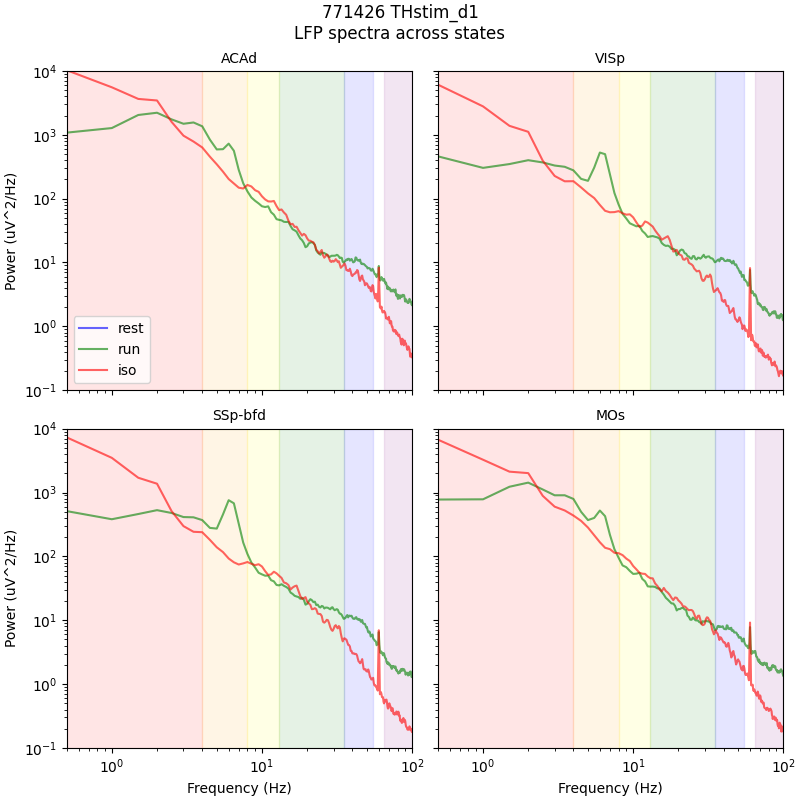

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(8,8), constrained_layout=True, sharex=True, sharey=True)
states = {'rest': 'blue', 'run': 'green', 'iso': 'red'}
for ax, (ctxi, stdict) in zip(axs.flatten(), ctx_spectra.items()):
    ax.set_title(ctxi)
    ## Highlight freq bands ##
    ax.axvspan(0.5, 4, color='red', alpha=0.1)
    ax.axvspan(4, 8, color='orange', alpha=0.1)
    ax.axvspan(8, 13, color='yellow', alpha=0.1)
    ax.axvspan(13, 35, color='green', alpha=0.1)
    ax.axvspan(35, 55, color='blue', alpha=0.1)
    ax.axvspan(65, 100, color='purple', alpha=0.1)
    ##
    for statei, stcol in states.items():
        ax.loglog(stdict[statei][0], stdict[statei][1], color=stcol, linewidth=1.5, alpha=0.6, label=statei)
# ax.set_xlim([0.5, 500])
# ax.set_ylim([1E-2, 1E4])
ax.set_xlim([0.5, 100])
ax.set_ylim([1E-1, 1E4])
axs[1,0].set_xlabel('Frequency (Hz)')
axs[1,1].set_xlabel('Frequency (Hz)')
axs[0,0].set_ylabel('Power (uV^2/Hz)')
axs[1,0].set_ylabel('Power (uV^2/Hz)')
axs[0,0].legend()
fig.suptitle('{} {}\nLFP spectra across states'.format(exp.mouse, exp_tag))

## Save ##
fig_name = '{}{}_spontLFPspectra_100Hz.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotdir, fig_name), transparent=False)

### Time-frequency analysis

In [78]:
np.max(np.abs(Zxx[frinds,:]))

346.62581907958213

In [79]:
np.min(np.abs(Zxx[frinds,:]))

1.1882967628518355e-05

Plot a combo plot

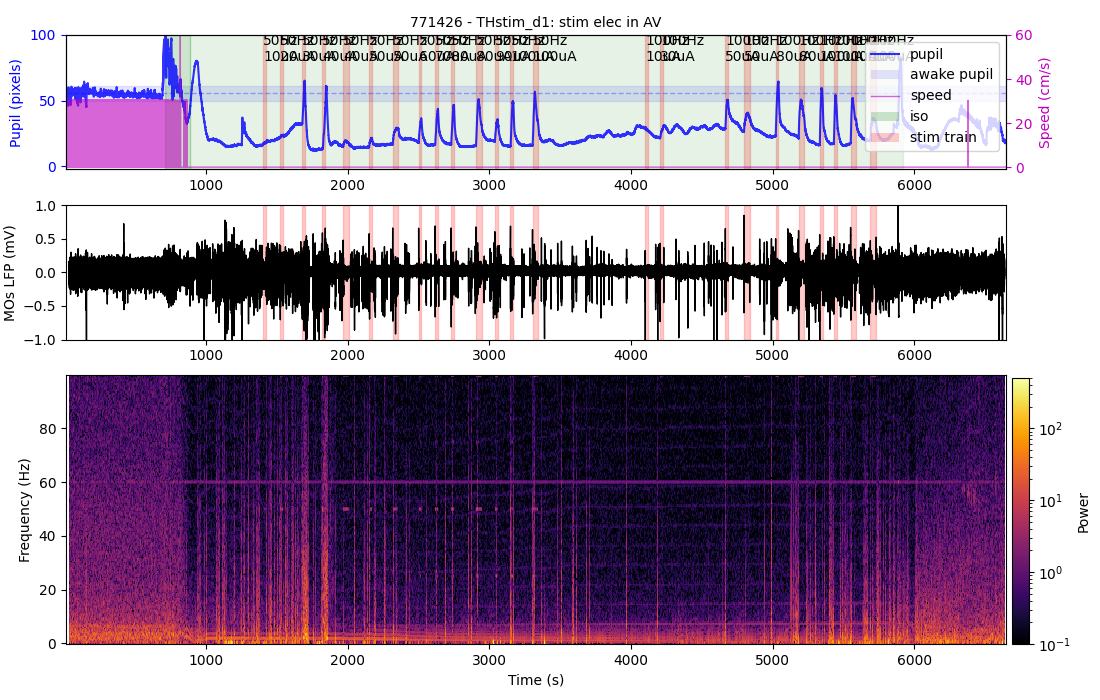

In [48]:
area = 'MOs'
freqlim = 100

# fig = plt.figure(figsize=(13.3,7.5))
fig = plt.figure(figsize=(11,7))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1,1,2], width_ratios=[3,0.01], wspace=0.1, left=0.06, right=0.96, top=0.95, bottom=0.08)

behaviorax = fig.add_subplot(gs[0,0])
lfpax = fig.add_subplot(gs[1,0], sharex=behaviorax)
stftax = fig.add_subplot(gs[2,0], sharex=behaviorax)

### Plot behavior ###
## Pupil ##
behaviorax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
behaviorax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc='b', alpha=0.1, label='awake pupil')
pup, = behaviorax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
behaviorax.set_xlim([pupilts[0], pupilts[-1]])
behaviorax.set_ylim([-2.5, 100])
behaviorax.set_ylabel('Pupil (pixels)', color='b')
behaviorax.tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    behaviorax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
    etag = traini.stim_type[4:] + '\n' + str(traini.parameter) + 'uA'
    behaviorax.annotate(etag, xy=(traini.onset, 80), xycoords='data')
    lfpax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
## Running ##
runax = behaviorax.twinx()
run, = runax.plot(speedts, speed, color='m', linewidth=1.0, alpha=0.6, label='speed')
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-1, 60])
## Iso level ##
behaviorax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
behaviorax.axvspan(iso_maintenance[0], iso_maintenance[1], color='g', alpha=0.1)
isp = mpatches.Rectangle((0, 0), 1, 1, fc='g', alpha=0.2, label='iso')
## Set title and legend ##
behaviorax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
behaviorax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

### Plot the filtered LFP ###
lfpax.plot(ctx_LFPs[area][0], ctx_LFPs[area][1] * 1E-3, color='k', linewidth=1.0)
lfpax.set_ylabel('{} LFP (mV)'.format(area))
lfpax.set_ylim([-1, 1])
# lfpax.set_title('{} LFP (filtered [0.5, 500] Hz)'.format(area))

### Plot the stft ###
frexx, times, Zxx = signal.stft(ctx_LFPs[area][1], lfp_fs, nperseg=2*lfp_fs)
frinds = np.nonzero(frexx < freqlim)[0]
Z = np.abs(Zxx[frinds,:])
tf = stftax.pcolormesh(times + lfp_ts[0], frexx[frinds], Z, norm=colors.LogNorm(vmin=1E-1, vmax=5E2), cmap='inferno', shading='auto')
# ax.set_yscale('log', base=10)
# ax.set_ylim([0.5, 100])
stftax.set_ylabel('Frequency (Hz)')
stftax.set_xlabel('Time (s)')

cbax = fig.add_axes([0.92, 0.08, 0.015, 0.38])
cbar = Colorbar(ax=cbax, mappable=tf, orientation='vertical', ticklocation='right', label='Power')
# cbar = fig.colorbar(tf, ax=cbax, label='Power')

## Save ##
fig_name = '{}{}_timefreq_{}LFP_{:d}Hz.png'.format(exp.mouse, exp_tag, area, freqlim)
# fig.savefig(os.path.join(plotdir, fig_name), transparent=False)

Plot small windows

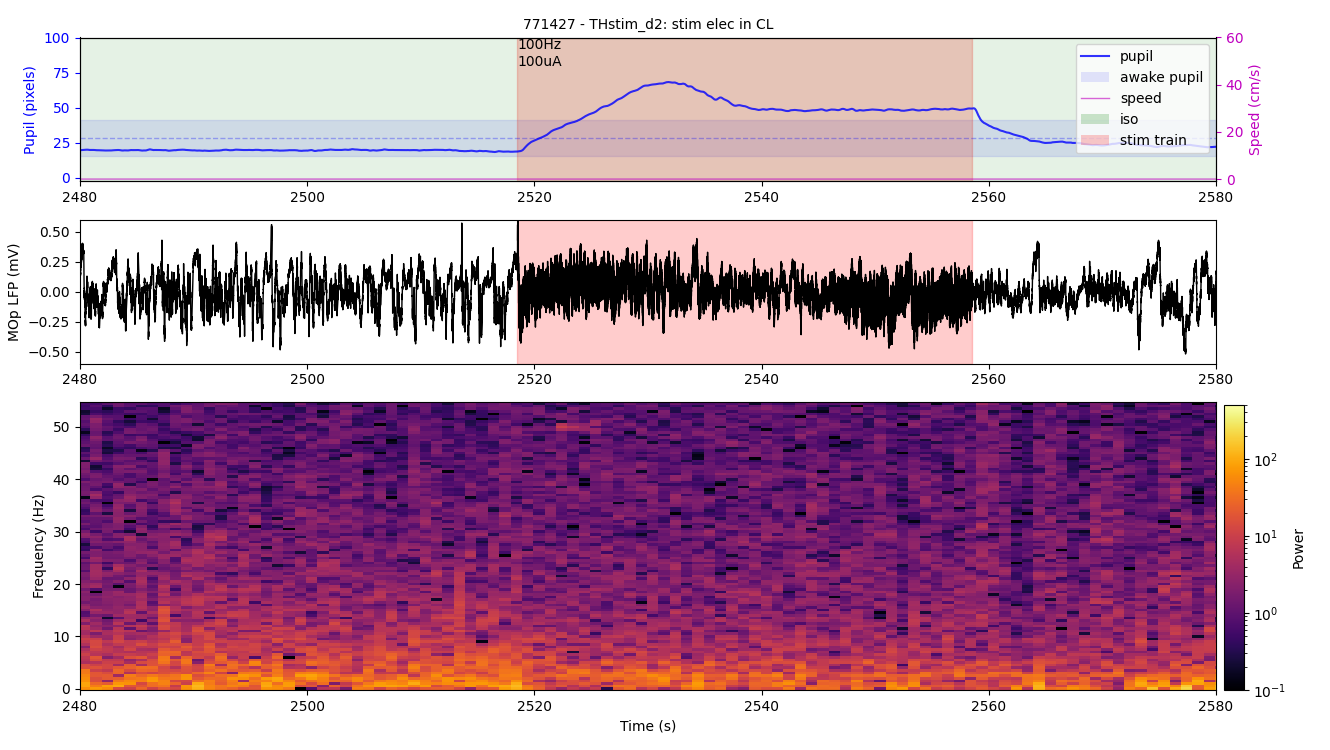

In [32]:
# area = 'MOp'
freqlim = 55
pwin = [2480, 2580]

fig = plt.figure(figsize=(13.3,7.5))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1,1,2], width_ratios=[3,0.01], wspace=0.1, left=0.06, right=0.96, top=0.95, bottom=0.08)

behaviorax = fig.add_subplot(gs[0,0])
lfpax = fig.add_subplot(gs[1,0], sharex=behaviorax)
stftax = fig.add_subplot(gs[2,0], sharex=behaviorax)

### Plot behavior ###
## Pupil ##
behaviorax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
behaviorax.axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc='b', alpha=0.1, label='awake pupil')
pup, = behaviorax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
# behaviorax.set_xlim([pupilts[0], pupilts[-1]])
behaviorax.set_xlim(pwin)
behaviorax.set_ylim([-2.5, 100])
behaviorax.set_ylabel('Pupil (pixels)', color='b')
behaviorax.tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    behaviorax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
    etag = traini.stim_type[4:] + '\n' + str(traini.parameter) + 'uA'
    behaviorax.annotate(etag, xy=(traini.onset, 80), xycoords='data')
    lfpax.axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
## Running ##
runax = behaviorax.twinx()
run, = runax.plot(speedts, speed, color='m', linewidth=1.0, alpha=0.6, label='speed')
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-1, 60])
## Iso level ##
behaviorax.axvspan(iso_induction[0], iso_induction[1], color='g', alpha=0.2)
behaviorax.axvspan(iso_maintenance[0], iso_maintenance[1], color='g', alpha=0.1)
isp = mpatches.Rectangle((0, 0), 1, 1, fc='g', alpha=0.2, label='iso')
## Set title and legend ##
behaviorax.set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
behaviorax.legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

### Plot the filtered LFP ###
lfpax.plot(ctx_LFPs[area][0], ctx_LFPs[area][1] * 1E-3, color='k', linewidth=1.0)
lfpax.set_ylabel('{} LFP (mV)'.format(area))
lfpax.set_ylim([-0.6, 0.6])
# lfpax.set_title('{} LFP (filtered [0.5, 500] Hz)'.format(area))

### Plot the stft ###
frexx, times, Zxx = signal.stft(ctx_LFPs[area][1], lfp_fs, nperseg=2*lfp_fs)
frinds = np.nonzero(frexx < freqlim)[0]
Z = np.abs(Zxx[frinds,:])
tf = stftax.pcolormesh(times + lfp_ts[0], frexx[frinds], Z, norm=colors.LogNorm(vmin=1E-1, vmax=5E2), cmap='inferno', shading='auto')
# ax.set_yscale('log', base=10)
# ax.set_ylim([0.5, 100])
stftax.set_ylabel('Frequency (Hz)')
stftax.set_xlabel('Time (s)')

cbax = fig.add_axes([0.92, 0.08, 0.015, 0.38])
cbar = Colorbar(ax=cbax, mappable=tf, orientation='vertical', ticklocation='right', label='Power')
# cbar = fig.colorbar(tf, ax=cbax, label='Power')

## Save ##
fig_name = '{}{}_timefreq_{}LFP_{:d}Hz_{:d}-{:d}s.png'.format(exp.mouse, exp_tag, area, freqlim, pwin[0], pwin[1])
fig.savefig(os.path.join(plotdir, fig_name), transparent=False)

In [138]:
np.max(speed)

60.74563920027139

#### Load a single ch

In [42]:
plot_ch = 380
lfpuv_ch = lfp_data_mm[:, plot_ch] * exp.ephys_params[probe_name]['bit_volts']

Text(0.5, 1.0, 'Raw LFP: probeF ch 380')

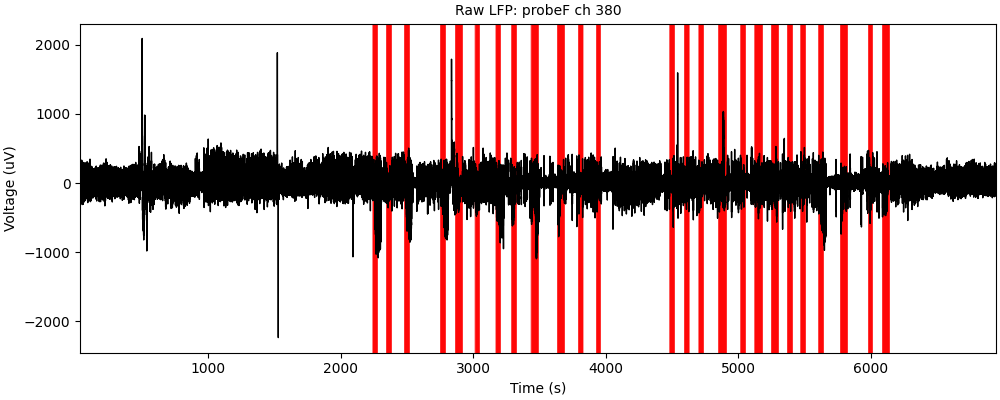

In [43]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
ax.plot(lfp_ts, lfpuv_ch, color='k', linewidth=1.0)
## Add stim events ##
for ii, stimi in stim_log.iterrows():
    ax.axvspan(stimi.onset, stimi.offset, color='r', alpha=0.1)
ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (uV)')
ax.set_title('Raw LFP: {} ch {:d}'.format(probe_name, plot_ch))

Get spectrum from rest, run, and iso

In [23]:
deltat = 10. # window size, s
awakebins = np.arange(lfp_ts[0], iso_induction[0], deltat)
firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)

In [24]:
tempsp = []
for x in awakebins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
awakespeeds = np.array(tempsp)[:-1]

tempsp = []
for x in isobins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
isospeeds = np.array(tempsp)[:-1]

In [44]:
awake_Pxx = []
for timei in awakebins[:-1]:
    tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
    frex, Pxx = signal.welch(
        lfpuv_ch[tinds], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probe_name]['lfp_sample_rate'],
    )
    awake_Pxx.append(Pxx)
awake_Pxx = np.array(awake_Pxx)
print(awake_Pxx.shape)
print(len(frex))

(68, 2501)
2501


In [45]:
iso_Pxx = []
for timei in isobins[:-1]:
    tinds = np.nonzero((lfp_ts >= timei) & (lfp_ts < timei + deltat))[0]
    frex, Pxx = signal.welch(
        lfpuv_ch[tinds], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2 * exp.ephys_params[probe_name]['lfp_sample_rate'],
    )
    iso_Pxx.append(Pxx)
iso_Pxx = np.array(iso_Pxx)
print(iso_Pxx.shape)

(133, 2501)


In [46]:
restPxx = np.mean(awake_Pxx[awakespeeds == 0, :], axis=0)
runPxx = np.mean(awake_Pxx[awakespeeds > 1, :], axis=0)
isoPxx = np.mean(iso_Pxx[isospeeds == 0, :], axis=0)

Text(0.5, 1.0, 'Raw LFP spectra: probeF, null')

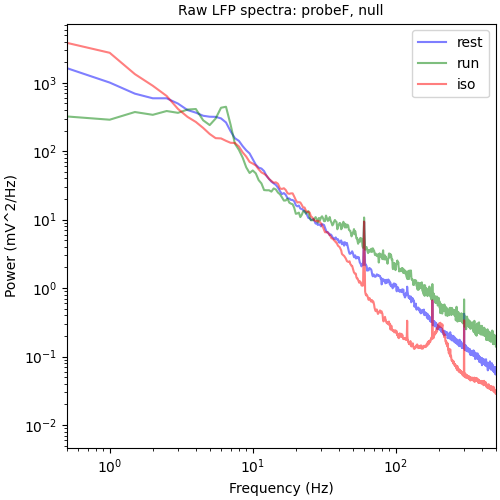

In [47]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.loglog(frex, restPxx, color='blue', linewidth=1.5, alpha=0.5, label='rest')
ax.loglog(frex, runPxx, color='green', linewidth=1.5, alpha=0.5, label='run')
ax.loglog(frex, isoPxx, color='red', linewidth=1.5, alpha=0.5, label='iso')
ax.set_xlim([0.5, 500])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.legend()
ax.set_title('Raw LFP spectra: {}, {}'.format(probe_name, probe_areas[plot_ch]))

#### Load all chs

In [21]:
ch_selection = np.arange(0, exp.ephys_params[probe_name]['num_chs'], 50)
comavg = np.mean(lfp_data_mm, axis=1)

Text(0, 0.5, 'Voltage (bits)')

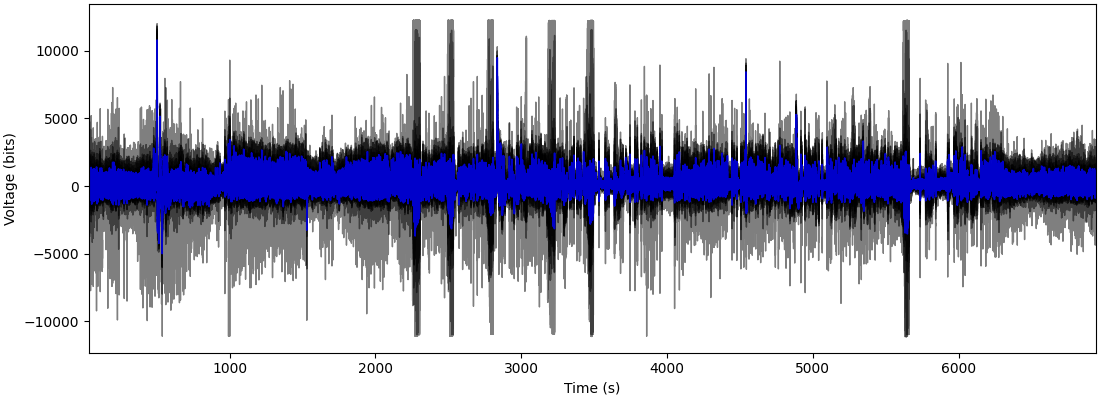

In [23]:
fig, ax = plt.subplots(figsize=(11,4), constrained_layout=True)
ax.plot(lfp_ts, lfp_data_mm[:, ch_selection], color='k', linewidth=1.0, alpha=0.5)
ax.plot(lfp_ts, comavg, color='b', linewidth=1.2, alpha=0.8)
ax.set_xlim([lfp_ts[0], lfp_ts[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (bits)')

### Plot spectrum

Load all LFP chs and convert

In [17]:
all_lfpuv = lfp_data_mm * exp.ephys_params[probe_name]['bit_volts']

In [20]:
ch_selection = np.arange(0, exp.ephys_params[probe_name]['num_chs'], 20)
frex, Pxx = signal.welch(
    all_lfpuv[:,ch_selection], exp.ephys_params[probe_name]['lfp_sample_rate'], nperseg=2*exp.ephys_params[probe_name]['lfp_sample_rate'], axis=0
)

Text(0.5, 1.0, 'Raw LFP spectrum: probeE')

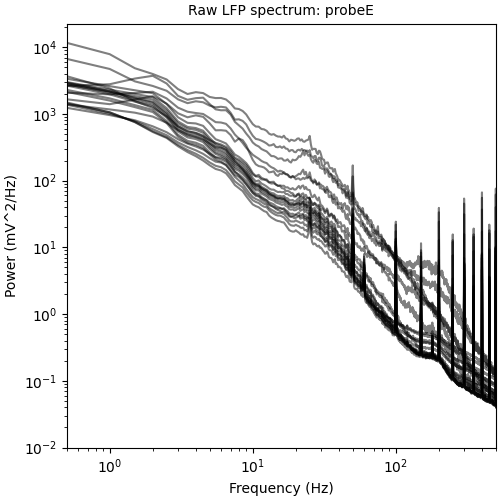

In [21]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)
ax.loglog(frex, Pxx, color='k', linewidth=1.5, alpha=0.5)
ax.set_xlim([0.5, 500])

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (mV^2/Hz)')
ax.set_title('Raw LFP spectrum: {}'.format(probe_name))